In [40]:
#!pip install hmmlearn ruptures seaborn shap xgboost

In [41]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
import ruptures as rpt
from scipy.stats import skew, kurtosis
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import xgboost
import shap

# 1. Data Importation and Cleaning

/var/folders/3_/t8l3yh8s28z9_jbq7gqy7byr0000gn/T/ipykernel_14345/3759571879.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


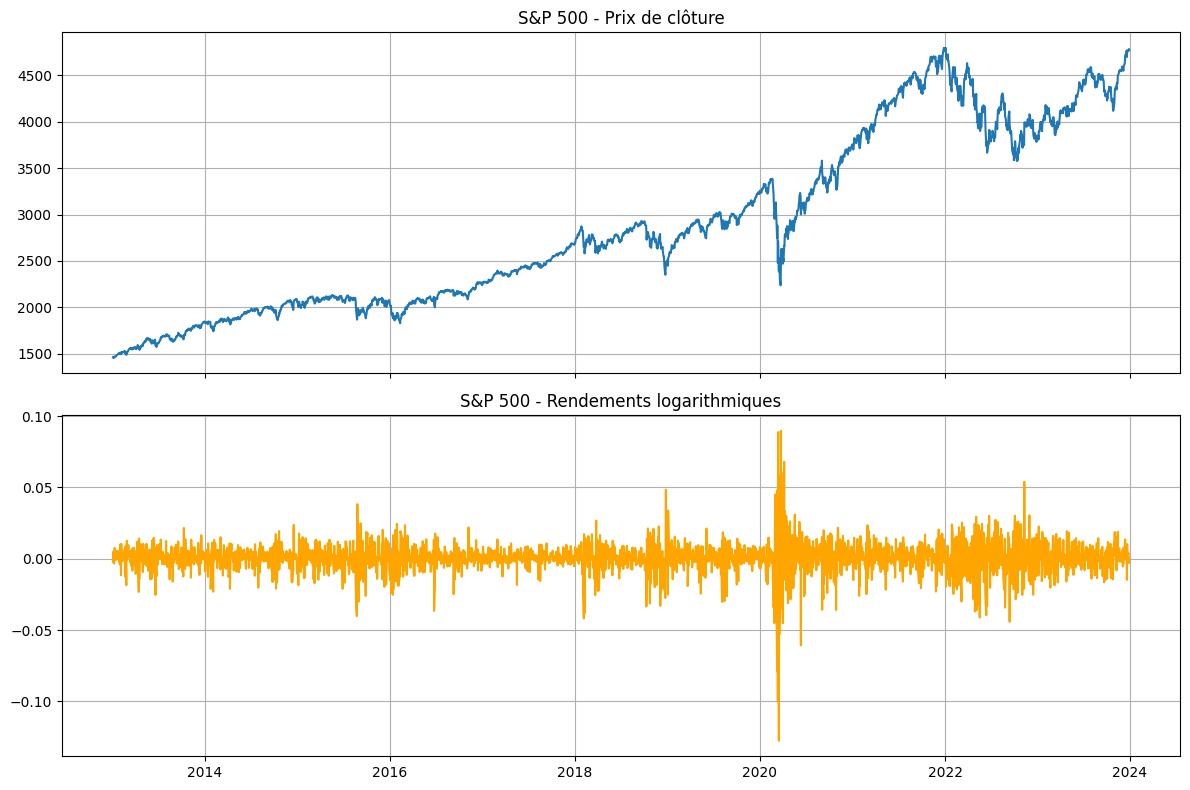

In [42]:
ticker = "^GSPC"  # S&P 500 index
start_date = "2013-01-01"
end_date = "2023-12-31"

data = yf.download(ticker, start=start_date, end=end_date)

data = data[["Close"]].rename(columns={"Close": "price"})
data.dropna(inplace=True)

data["log_return"] = np.log(data["price"] / data["price"].shift(1))
data.dropna(inplace=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(data.index, data["price"], label="S&P 500 Price")
ax1.set_title("S&P 500 - Prix de clôture")
ax1.grid(True)

ax2.plot(data.index, data["log_return"], color="orange", label="Log-return")
ax2.set_title("S&P 500 - Rendements logarithmiques")
ax2.grid(True)

plt.tight_layout()
plt.show()


# 2. Training of a Hidden Markov Model using HMMlearn

We set 3 hidden states <br>
.fit uses the E-M algorithm to find the transition probas and emission probas <br>
.predict uses the Viterbi algorithm to find the most probable sequence of hidden states, knowning the emissions

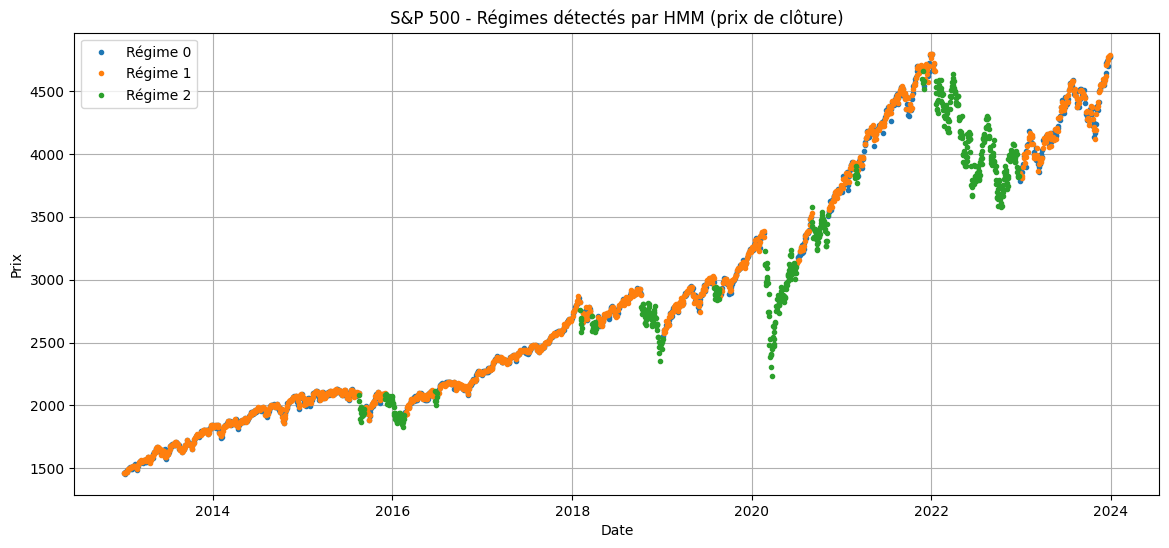

In [43]:
# hmmlearn attend un tableau 2D : (n_samples, n_features)
returns = data["log_return"].values.reshape(-1, 1)
n_states = 3

model = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=1000, random_state=42)
model.fit(returns)

hidden_states = model.predict(returns)
data["regime"] = hidden_states

plt.figure(figsize=(14, 6))

for i in range(n_states):
    state = data[data["regime"] == i]
    plt.plot(state.index, state["price"], ".", label=f"Régime {i}")

plt.title("S&P 500 - Régimes détectés par HMM (prix de clôture)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid(True)
plt.show()


# 3. Interpretation of the 3 hidden states (Bull, Bear, Calm)

In [44]:
model

,n_components,3
,covariance_type,'full'
,min_covar,0.001
,startprob_prior,1.0
,transmat_prior,1.0
,means_prior,0
,means_weight,0
,covars_prior,0.01
,covars_weight,1
,algorithm,'viterbi'
,random_state,42


In [45]:
model.means_

array([[ 0.00044582],
       [ 0.00130699],
       [-0.00175562]])

In [46]:
model.covars_

array([[[6.67599742e-05]],

       [[4.90353769e-05]],

       [[4.62002105e-04]]])

In [47]:
for i in range(n_states):
    mean = model.means_[i][0]
    var = np.sqrt(model.covars_[i][0][0])
    print(f"Régime {i} : moyenne = {mean:.5f}, écart-type = {var:.5f}")

Régime 0 : moyenne = 0.00045, écart-type = 0.00817
Régime 1 : moyenne = 0.00131, écart-type = 0.00700
Régime 2 : moyenne = -0.00176, écart-type = 0.02149


# 4. Detection of rupture point using Ruptures

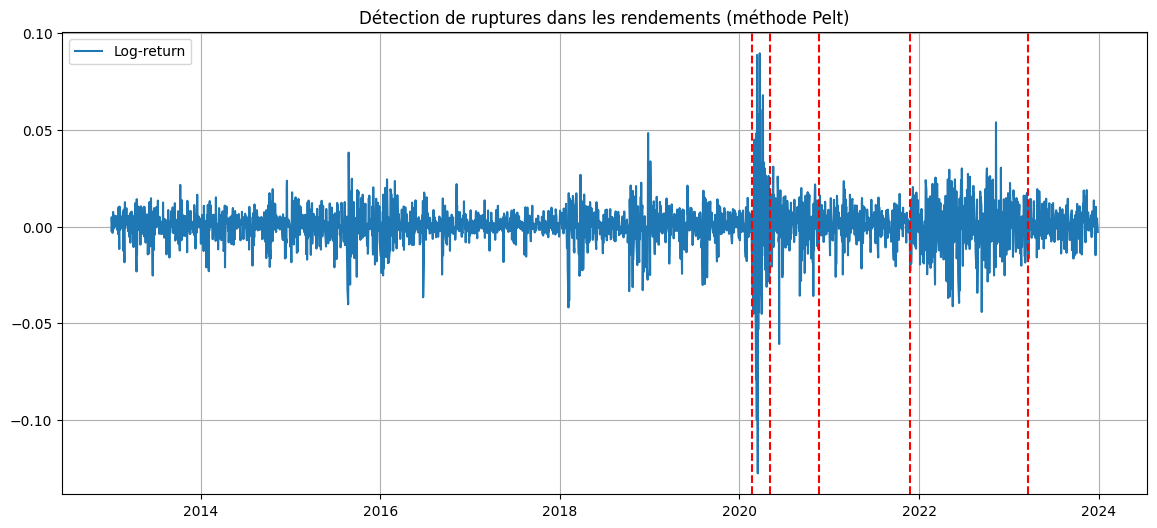

In [48]:
# We choose to analyze log returns but give another option after

signal = data["log_return"].values
# Option 2 : Mobile Vol (rolling std over 20 days)
#signal = data["log_return"].rolling(window=20).std().dropna().values

#We use method Pelt and loss rbf
'''algo = rpt.Pelt(model="rbf").fit(signal)
breakpoints = algo.predict(pen=10)'''

# Option 2 : We can also force a number of rupture points but need to use another model than Pelt
algo = rpt.Binseg(model="rbf").fit(signal)
breakpoints = algo.predict(n_bkps=5)  

plt.figure(figsize=(14, 6))
plt.plot(data.index, signal, label="Log-return")
for bkpt in breakpoints:
    if bkpt < len(data):
        plt.axvline(data.index[bkpt], color='red', linestyle='--')
plt.title("Détection de ruptures dans les rendements (méthode Pelt)")
plt.grid(True)
plt.legend()
plt.show()


# 5. Comparison of HMM and Ruptures

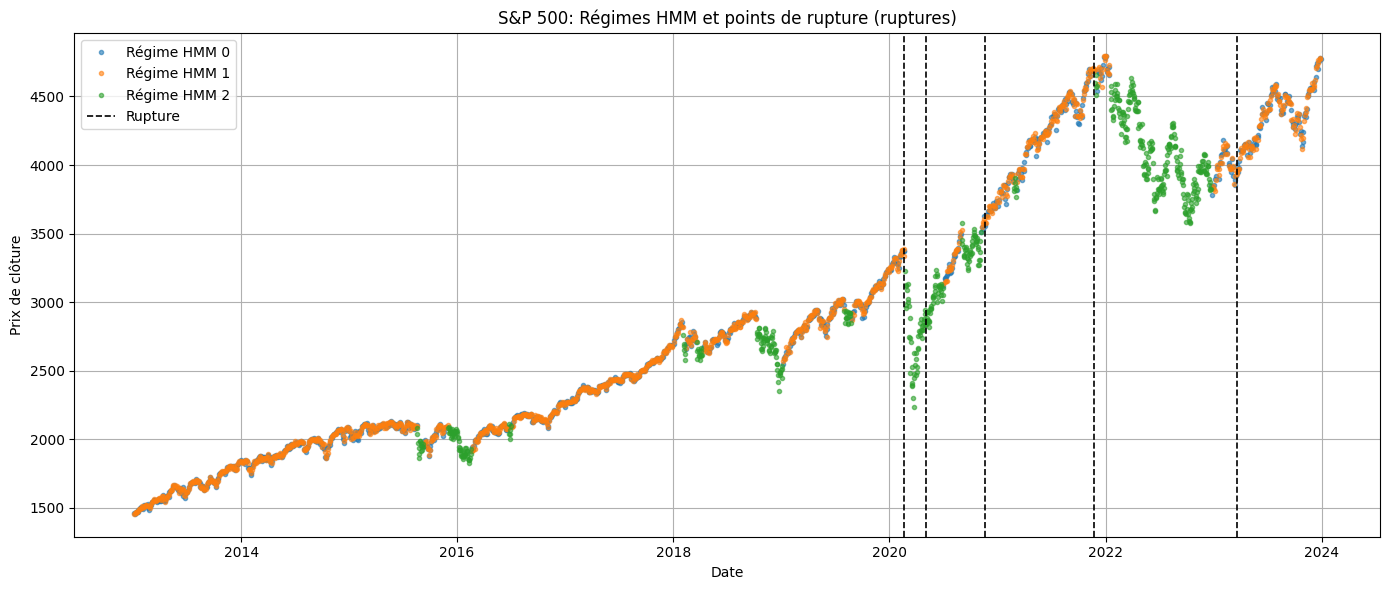

In [49]:
plt.figure(figsize=(14, 6))

for i in range(n_states):
    state = data[data["regime"] == i]
    plt.plot(state.index, state["price"], '.', label=f"Régime HMM {i}", alpha=0.6)

for bkpt in breakpoints:
    if bkpt < len(data):
        plt.axvline(data.index[bkpt], color="black", linestyle="--", linewidth=1.2, label="Rupture" if bkpt == breakpoints[0] else None)

plt.title("S&P 500: Régimes HMM et points de rupture (ruptures)")
plt.xlabel("Date")
plt.ylabel("Prix de clôture")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 6. Analysis of features to better understand the HMM regimes

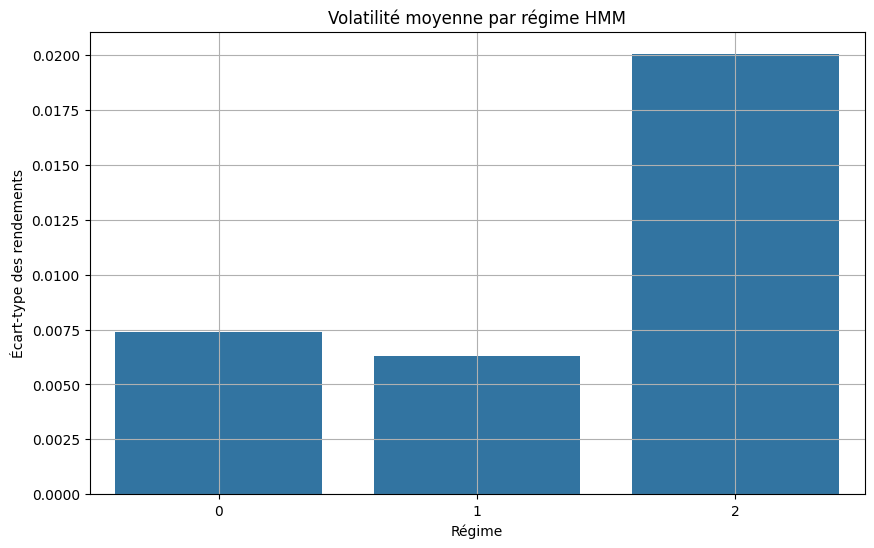

,regime,count,mean,std (volatility),skew,kurtosis
0,1,1110,0.001353,0.006280,-0.053112,0.543575
1,0,1106,0.000400,0.007398,-0.318854,0.942829
2,2,551,-0.001383,0.020041,-0.382658,5.168180


In [50]:
features = []

for i in range(n_states):
    subset = data[data["regime"] == i]["log_return"]
    stats = {
        "regime": i,
        "count": len(subset),
        "mean": subset.mean(),
        "std (volatility)": subset.std(),
        "skew": skew(subset),
        "kurtosis": kurtosis(subset),
    }
    features.append(stats)

features_df = pd.DataFrame(features).sort_values(by="std (volatility)", ascending=True)
features_df.reset_index(drop=True, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=features_df, x="regime", y="std (volatility)")
plt.title("Volatilité moyenne par régime HMM")
plt.ylabel("Écart-type des rendements")
plt.xlabel("Régime")
plt.grid(True)
plt.show()

display(features_df)


# Part 2 : ML models to predict regimes

We now use the basis we got with HMM for the regimes to train classification models to predict the regimes 

In [51]:
data

Price,price,log_return,regime
Ticker,^GSPC,,
Date,,,
2013-01-03,1459.369995,-0.002088,1
2013-01-04,1466.469971,0.004853,0
2013-01-07,1461.890015,-0.003128,1
2013-01-08,1457.150024,-0.003248,0
2013-01-09,1461.020020,0.002652,1
...,...,...,...
2023-12-22,4754.629883,0.001659,0
2023-12-26,4774.750000,0.004223,1


## 1. Creation of features

In [52]:
rolling_size = 15 
data['rolling_mean'] = data['log_return'].rolling(window=rolling_size).mean()
data['rolling_std'] = data['log_return'].rolling(window=rolling_size).std()
data['rolling_skew'] = data['log_return'].rolling(window=rolling_size).apply(skew)
data['rolling_kurtosis'] = data['log_return'].rolling(window=rolling_size).apply(kurtosis)
data['momentum'] = data['price'] - data['price'].rolling(window=rolling_size).mean()
data['lag1'] = data['log_return'].shift(1)
data['lag2'] = data['log_return'].shift(2)
data['lag3'] = data['log_return'].shift(3)
data["regime_future"] = data["regime"].shift(-1)
data.dropna(inplace=True)

data.head()

Price,price,log_return,regime,rolling_mean,rolling_std,rolling_skew,rolling_kurtosis,momentum,lag1,lag2,lag3,regime_future
Ticker,^GSPC,,,,,,,,,,,
Date,,,,,,,,,,,,
2013-01-24,1494.819946,0.000007,1,0.001461,0.003248,0.228797,-0.899266,20.497941,0.001506,0.004418,0.003397,0.0
2013-01-25,1502.959961,0.005431,0,0.001962,0.003242,-0.021269,-0.960551,25.731958,0.000007,0.001506,0.004418,1.0
2013-01-28,1500.180054,-0.001851,1,0.001515,0.003277,0.238478,-0.937422,20.704712,0.005431,0.000007,0.001506,0.0
2013-01-29,1507.839966,0.005093,0,0.002063,0.003129,0.076200,-1.012793,25.301294,-0.001851,0.005431,0.000007,1.0
2013-01-30,1501.959961,-0.003907,1,0.002019,0.003212,-0.027669,-0.872761,16.433960,0.005093,-0.001851,0.005431,0.0


## 2. Data split

In [53]:
X = data.drop(columns=['regime','price','log_return','regime_future']) 
y = data["regime"]
y_future = data['regime_future']

split_index = int(len(X) * 0.7)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]


In [54]:
tscv = TimeSeriesSplit(n_splits=5)

for train_idx, val_idx in tscv.split(X):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

# 3. Model Training

## 3.1 Random Forest

Accuracy: 0.58
              precision    recall  f1-score   support

           0       0.50      0.44      0.47       271
           1       0.52      0.48      0.50       271
           2       0.69      0.82      0.75       284

    accuracy                           0.58       826
   macro avg       0.57      0.58      0.57       826
weighted avg       0.57      0.58      0.57       826



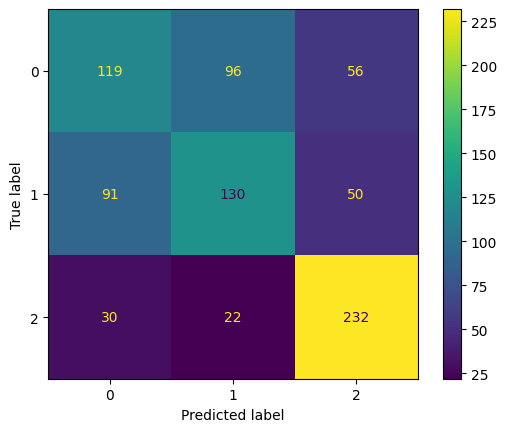

In [55]:
RF = RandomForestClassifier(random_state=42)

RF.fit(X_train, y_train)
y_pred_rf = RF.predict(X_test) 


accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

print(classification_report(y_test, y_pred_rf))

## 3.2 Logistic Regression

always scale for linear models !

Accuracy: 0.56
              precision    recall  f1-score   support

           0       0.44      0.38      0.41       271
           1       0.47      0.64      0.55       271
           2       0.85      0.66      0.74       284

    accuracy                           0.56       826
   macro avg       0.59      0.56      0.56       826
weighted avg       0.59      0.56      0.57       826



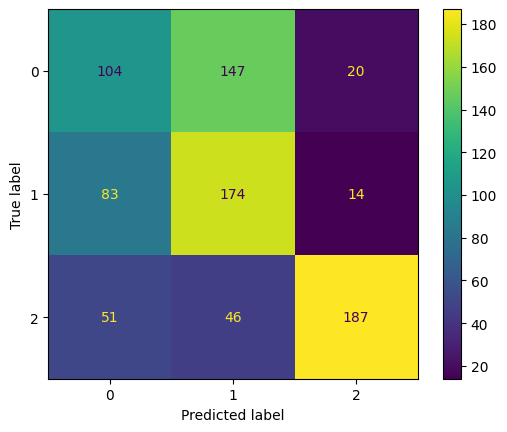

In [56]:
LR = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))

LR.fit(X_train, y_train)
y_pred_lr = LR.predict(X_test) 

accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

print(classification_report(y_test, y_pred_lr))

## 3.3 XGBoost

Accuracy: 0.58
              precision    recall  f1-score   support

           0       0.47      0.39      0.43       271
           1       0.49      0.58      0.53       271
           2       0.78      0.77      0.77       284

    accuracy                           0.58       826
   macro avg       0.58      0.58      0.58       826
weighted avg       0.58      0.58      0.58       826



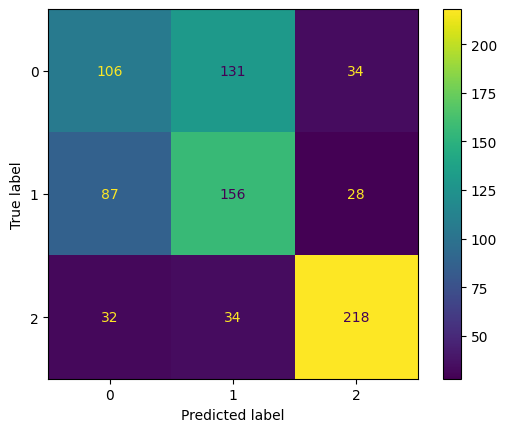

In [57]:
XGB = xgboost.XGBClassifier(random_state=42)

XGB.fit(X_train, y_train)
y_pred_xgb = XGB.predict(X_test) 

accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

print(classification_report(y_test, y_pred_xgb))

## 4. Performance Summary

In [58]:
performance_summary = {
    "Model": [],
    "Accuracy": [],
    "F1 Macro": [],
    "F1 Class 0": [],
    "F1 Class 1": [],
    "F1 Class 2": [],
}

models = {
    "Logistic Regression": y_pred_lr,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb
}

for name, y_pred in models.items():
    f1 = f1_score(y_test, y_pred, average=None)
    performance_summary["Model"].append(name)
    performance_summary["Accuracy"].append(accuracy_score(y_test, y_pred))
    performance_summary["F1 Macro"].append(f1_score(y_test, y_pred, average="macro"))
    performance_summary["F1 Class 0"].append(f1[0])
    performance_summary["F1 Class 1"].append(f1[1])
    performance_summary["F1 Class 2"].append(f1[2])

import pandas as pd

performance_df = pd.DataFrame(performance_summary)
display(performance_df)


,Model,Accuracy,F1 Macro,F1 Class 0,F1 Class 1,F1 Class 2
0,Logistic Regression,0.562954,0.564898,0.408644,0.545455,0.740594
1,Random Forest,0.582324,0.570899,0.465753,0.500963,0.745981
2,XGBoost,0.581114,0.575832,0.427419,0.527027,0.773050


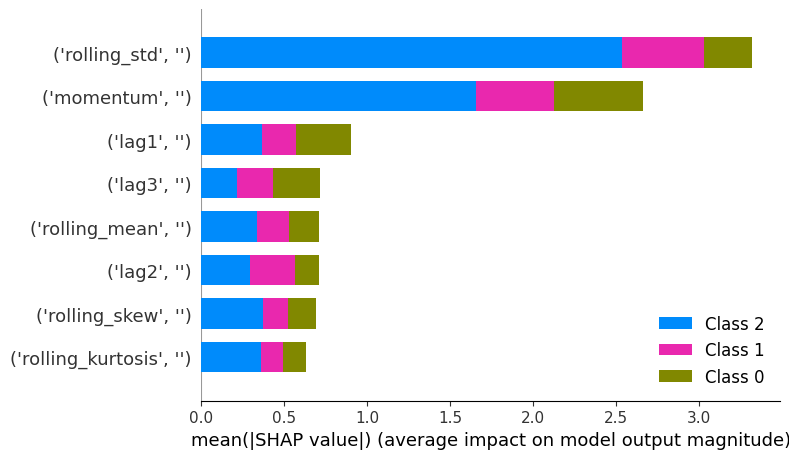

In [59]:
explainer = shap.Explainer(XGB)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

## 5. Plot of results

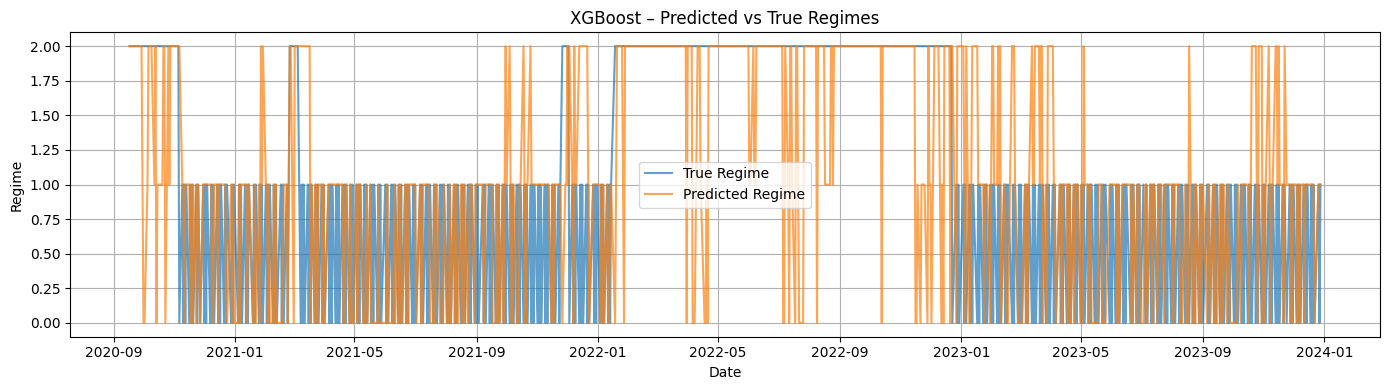

In [60]:
def plot_regime_predictions(y_true, y_pred, title):
    plt.figure(figsize=(14, 4))
    plt.plot(y_true.index, y_true, label="True Regime", alpha=0.7)
    plt.plot(y_true.index, y_pred, label="Predicted Regime", alpha=0.7)
    plt.title(title)
    plt.ylabel("Regime")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_regime_predictions(y_test, y_pred_xgb, "XGBoost – Predicted vs True Regimes")


## 6. Fine Tuning for XGBoost

In [61]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
}

In [62]:
xgb_model = xgboost.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="mlogloss")

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring="f1_macro",  # Or "accuracy" depending on your focus
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/Users/julesarzel/Documents/M2ISF/Portfolio_Opti/Portfolio_Opti/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:24:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/julesarzel/Documents/M2ISF/Portfolio_Opti/Portfolio_Opti/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:24:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/julesarzel/Documents/M2ISF/Portfolio_Opti/Portfolio_Opti/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:24:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/julesarzel/Documents/M2ISF/Portfolio_Opti/Portfolio_Opti/.venv/lib/py

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.05, 0.1], 'max_depth': [3, 5], 'n_estimators': [100, 200], 'subsample': [0.8, 1.0]}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'multi:softprob'


In [63]:
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Macro Score:", grid_search.best_score_)

Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best F1 Macro Score: 0.5058206272473769


              precision    recall  f1-score   support

           0       0.47      0.45      0.46       271
           1       0.50      0.47      0.48       271
           2       0.73      0.79      0.76       284

    accuracy                           0.58       826
   macro avg       0.57      0.57      0.57       826
weighted avg       0.57      0.58      0.57       826



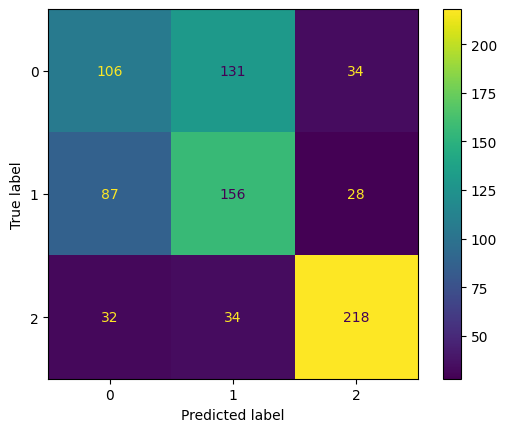

In [64]:
best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)

print(classification_report(y_test, y_pred_best))

cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## 7. Predict future Regimes

/Users/julesarzel/Documents/M2ISF/Portfolio_Opti/Portfolio_Opti/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:25:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Prediction of future regimes (t+1):
              precision    recall  f1-score   support

           0       0.36      0.28      0.31       271
           1       0.38      0.39      0.39       271
           2       0.65      0.77      0.71       284

    accuracy                           0.49       826
   macro avg       0.46      0.48      0.47       826
weighted avg       0.47      0.49      0.47       826



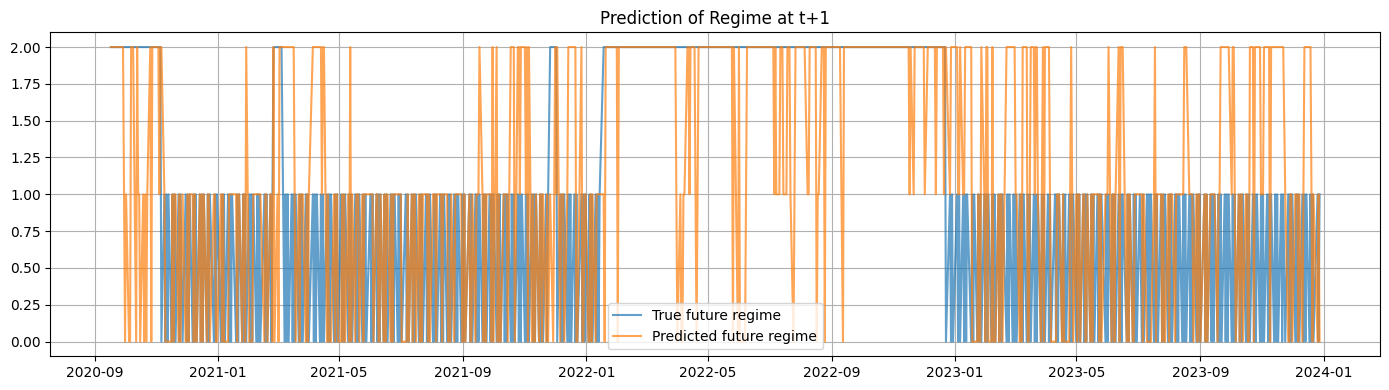

In [66]:
y_train, y_test = y_future.iloc[:split_index], y.iloc[split_index:]

best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)

print("Prediction of future regimes (t+1):")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(14, 4))
plt.plot(y_test.index, y_test, label="True future regime", alpha=0.7)
plt.plot(y_test.index, y_pred, label="Predicted future regime", alpha=0.7)
plt.title("Prediction of Regime at t+1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()